<a href="https://colab.research.google.com/github/Alfonso-Jesus-Garcia-Moya/Value_at_Risk_GBM_MONTERCARLO_volatility_Diferencial/blob/main/RISK_MODELING_ENGINE_LEVERAGE_MONTE_CARLO_SIMULATION%2C_GEOMETRIC_BROWNIAN_MOTION.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

/tmp/ipython-input-2661300831.py:28: FutureWarning: YF.download() has changed argument auto_adjust default to True
  raw_data = yf.download(TICKER, period="1y", progress=False)['Close']


--- PARÁMETROS CALIBRADOS PARA PLTR ---
Precio Inicial (S0): 188.71
Drift Diario (mu): 0.002613
Volatilidad Diaria (sigma): 0.041947
Output 0 generado: Historia guardada en CSV y variables listas.


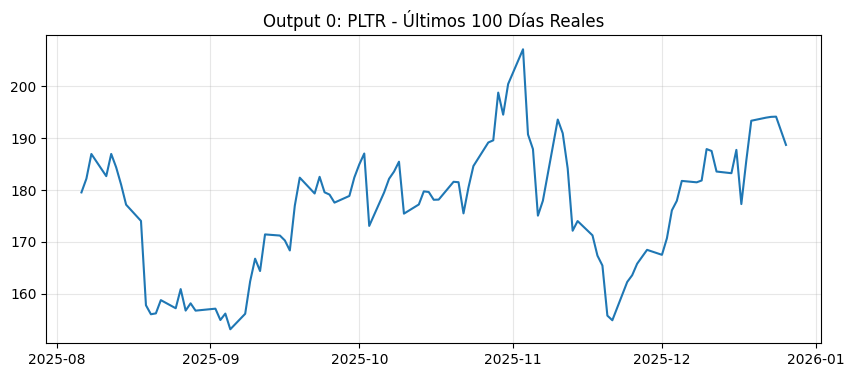

In [2]:
# CÓDIGO PARTE 1: Configuración, Datos y Calibración Esta celda prepara el terreno.
#Descarga Palantir (PLTR), calcula los parámetros reales ($\mu$ y $\sigma$)
#y prepara los CSVs históricos.

# Log Returns: No usamos precios, usamos np.log(P_hoy / P_ayer).
# Esto normaliza la serie para que sea "sumable" en el tiempo.
# Calibración: Hemos extraído el ADN de Palantir.sigma:
# Qué tan violento se mueve PLTR diariamente.drift:
# La tendencia "pura" descontando la volatilidad (
# Recuerda el término $-\frac{1}{2}\sigma^2$).
# S0: Hemos fijado el punto de partida para los 1,000 universos.

import numpy as np
import pandas as pd
import yfinance as yf
import matplotlib.pyplot as plt
from scipy.stats import norm

# --- CONFIGURACIÓN ---
TICKER = "PLTR"
DIAS_ATRAS = 100    # Para gráfica histórica
DIAS_PROYECCION = 100 # T (Horizonte de tiempo)
NUM_SIMULACIONES = 1000 # N (Universos)
SEMILLA = 42 # Para que sea replicable (Determinismo en el desarrollo)

# 1. OBTENCIÓN DE DATOS (OUTPUT 0)
# Descargamos 1 año para tener buena data estadística, luego cortamos
raw_data = yf.download(TICKER, period="1y", progress=False)['Close']

# Calcular Retornos Logarítmicos (Es la base de todo el modelo)
log_returns = np.log(raw_data / raw_data.shift(1)).dropna()

# CALIBRACIÓN DE PARÁMETROS (LAS TRIPAS)
# Drift (mu) y Volatilidad (sigma) DIARIOS
mu = log_returns.mean()
var = log_returns.var()
sigma = log_returns.std() # Volatilidad diaria

# Drift ajustado por convexidad (mu - 0.5 * sigma^2)
drift = mu - (0.5 * var)

# Preparar DataFrame Histórico para Output 0 (Últimos 100 días reales)
historia_reiente = raw_data.iloc[-DIAS_ATRAS:]
ultimo_precio = historia_reiente.iloc[-1].item() # S0

# --- GUARDAR OUTPUT 0 (HISTORIA) ---
historia_reiente.to_csv("0_PLTR_Historia_100dias.csv")

print(f"--- PARÁMETROS CALIBRADOS PARA {TICKER} ---")
print(f"Precio Inicial (S0): {ultimo_precio:.2f}")
print(f"Drift Diario (mu): {drift.item():.6f}")
print(f"Volatilidad Diaria (sigma): {sigma.item():.6f}")
print("Output 0 generado: Historia guardada en CSV y variables listas.")

# Gráfico Rápido de Validación de Historia
plt.figure(figsize=(10,4))
plt.plot(historia_reiente.index, historia_reiente.values)
plt.title(f"Output 0: {TICKER} - Últimos {DIAS_ATRAS} Días Reales")
plt.grid(True, alpha=0.3)
plt.show()

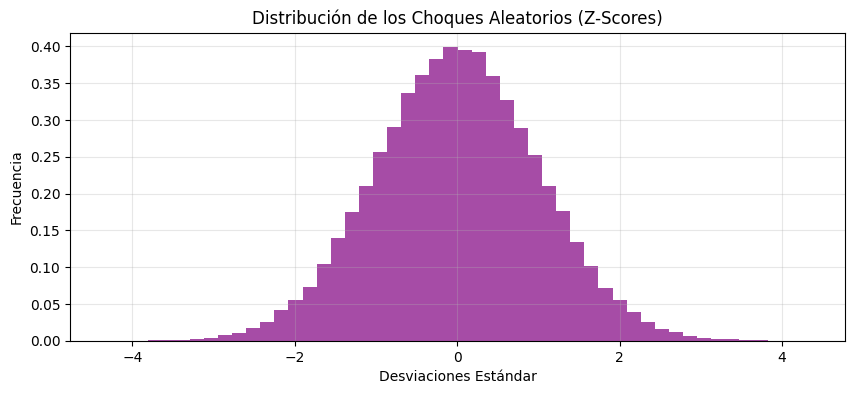

Output 1 Generado: Matriz Z creada y guardada.
Output 2 Generado: 1000 caminos simulados calculados.


/tmp/ipython-input-1159126371.py:46: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  drift = float(drift)
/tmp/ipython-input-1159126371.py:47: FutureWarning: Calling float on a single element Series is deprecated and will raise a TypeError in the future. Use float(ser.iloc[0]) instead
  sigma = float(sigma)


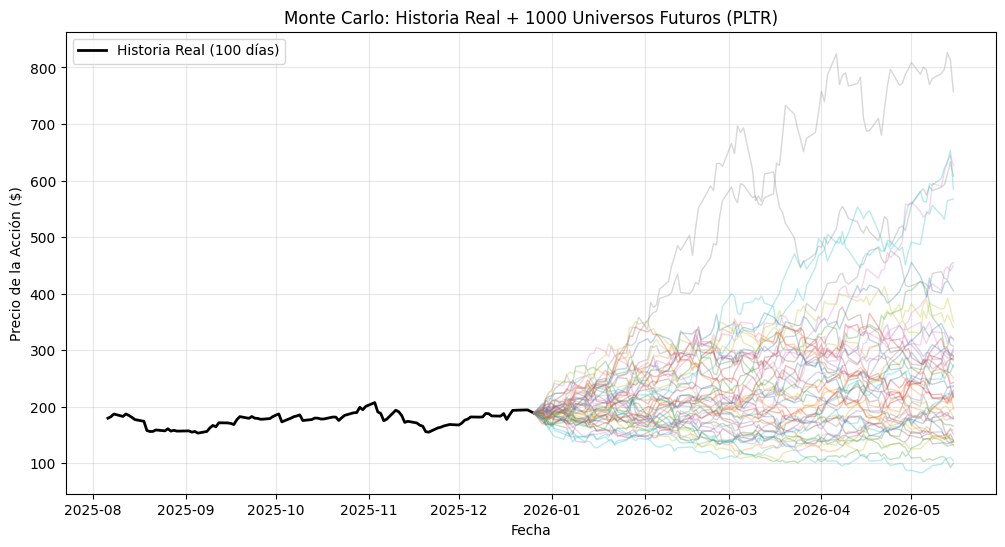

In [9]:
# CÓDIGO PARTE 2: Generación Estocástica (Z) y Motor GBM

# Explicación de las variables clave generadas:
# Z_matrix: Tu materia prima estocástica. Es una matriz de 100 filas x 1000 columnas.
# Cada número ahí es una intensidad de choque.

# daily_log_returns: Aquí aplicamos la fórmula de "Tendencia + Volatilidad".
# Es la matriz de porcentajes de cambio diario (en logaritmo).

# simulated_prices: El resultado final. Usamos np.cumsum (Suma Acumulada)
# porque en los logaritmos, sumar retornos equivale a multiplicar precios
#  (interés compuesto). Luego np.exp lo devuelve a dinero real.

# ==========================================
# BLOQUE 2: MOTOR DE SIMULACIÓN (GBM)
# ==========================================

# --- 1. GENERACIÓN DE LA MATRIZ DE CHOQUE (OUTPUT 1) ---
# Se genera una matriz (T x N) de variables aleatorias normales estándar.
# Z ~ N(0, 1)
# Filas: Días de proyección. Columnas: Universos (Simulaciones).
Z_matrix = np.random.normal(0, 1, (DIAS_PROYECCION, NUM_SIMULACIONES))

# Guardar Matriz Z en CSV (Solo primeros 100 universos para no saturar disco si N es muy grande)
pd.DataFrame(Z_matrix[:, :100]).to_csv("1_Matriz_Z_Scores.csv", index=False)

# Validación Visual de Z (Debe parecer una campana de Gauss perfecta)
plt.figure(figsize=(10, 4))
plt.hist(Z_matrix.flatten(), bins=50, color='purple', alpha=0.7, density=True)
plt.title("Distribución de los Choques Aleatorios (Z-Scores)")
plt.xlabel("Desviaciones Estándar")
plt.ylabel("Frecuencia")
plt.grid(True, alpha=0.3)
plt.show()

print("Output 1 Generado: Matriz Z creada y guardada.")


# --- 2. CÁLCULO DE CAMINOS DE PRECIO - GBM (OUTPUT 2) ---
# Aplicación vectorizada de la fórmula de Euler para GBM:
# S_t = S_0 * exp( cumsum( (mu - 0.5*sigma^2) + sigma * Z ) )

# --- CORRECCIÓN DE DEBUGGING ---
# Convertimos los valores de Pandas a números puros (floats)
# Esto elimina cualquier índice o formato de tabla que esté estorbando.
drift = float(drift)
sigma = float(sigma)

# Ahora sí, la línea 45 funcionará porque son (Número + Matriz)

# En Python científico, esto se llama Broadcasting (Difusión).

# NumPy sabe sumar 1 + [Matriz]: Toma el 1 y lo suma a cada celda.

# NumPy NO sabe sumar Serie_Pandas + [Matriz]: Porque la Serie tiene un índice (fecha o nombre)
#  y NumPy no sabe si quieres sumar ese número a las filas, a las columnas,
#  o si debe buscar un índice coincidente.

# Al usar float(), le dices a Python: "Olvida las etiquetas, dame solo el valor numérico".


# A. Calcular los Retornos Logarítmicos Diarios para cada celda de la matriz
# drift y sigma vienen del Bloque 1
daily_log_returns = drift + (sigma * Z_matrix)

# B. Acumular los retornos en el tiempo (Random Walk)
cumulative_log_returns = np.cumsum(daily_log_returns, axis=0)

# C. Convertir a Precios Reales usando la función Exponencial
# Se multiplica por el último precio real conocido (S0)
simulated_prices = ultimo_precio * np.exp(cumulative_log_returns)

# --- 3. ESTRUCTURACIÓN DE DATOS PARA REPORTE ---
# Insertar el precio inicial (S0) como "Día 0" en todas las simulaciones
# Esto conecta visualmente la historia con la proyección.
S0_row = np.full((1, NUM_SIMULACIONES), ultimo_precio)
simulated_prices_concat = np.vstack([S0_row, simulated_prices])

# Crear DataFrame de Pandas para fácil manipulación
df_simulaciones = pd.DataFrame(simulated_prices_concat)

# Guardar Resultados de Simulaciones en CSV
df_simulaciones.to_csv("2_GBM_Simulaciones_Precios.csv", index=False)
print(f"Output 2 Generado: {NUM_SIMULACIONES} caminos simulados calculados.")


# --- 4. VISUALIZACIÓN COMPLETA (HISTORIA + PROYECCIÓN) ---
plt.figure(figsize=(12, 6))

# A. Graficar Historia Real (Negro Sólido)
plt.plot(historia_reiente.index, historia_reiente.values, color='black', linewidth=2, label='Historia Real (100 días)')

# B. Graficar Simulaciones (Líneas finas de colores)
# Generar índice de fechas futuras para el eje X
last_date = historia_reiente.index[-1]
future_dates = pd.date_range(start=last_date, periods=DIAS_PROYECCION + 1, freq='B') # 'B' para días hábiles

# Graficar solo los primeros 50 universos para estética visual (evitar mancha sólida)
plt.plot(future_dates, df_simulaciones.iloc[:, :50].values, alpha=0.3, linewidth=1)

# Estética del Gráfico
plt.title(f"Monte Carlo: Historia Real + {NUM_SIMULACIONES} Universos Futuros ({TICKER})")
plt.ylabel("Precio de la Acción ($)")
plt.xlabel("Fecha")
plt.legend(loc='upper left')
plt.grid(True, alpha=0.3)
plt.show()

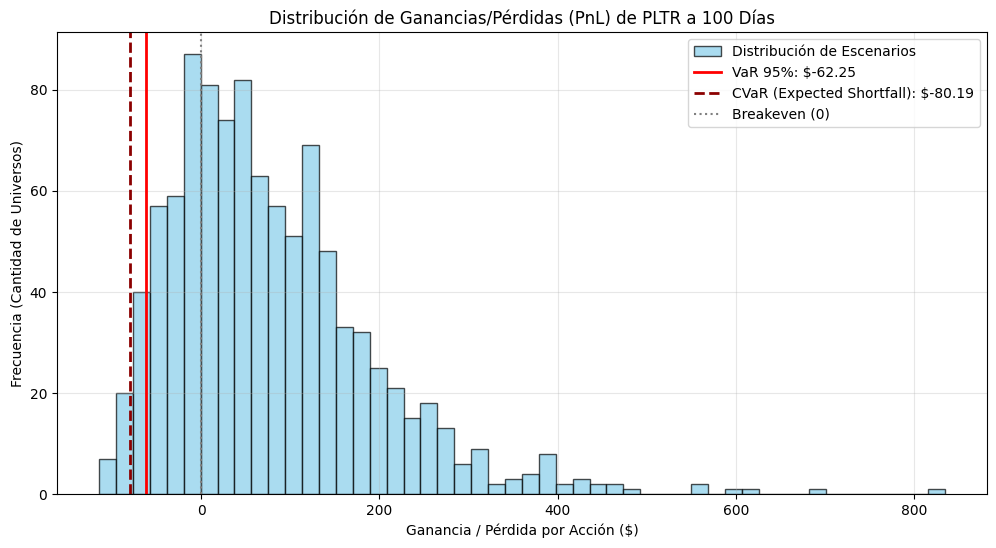

REPORTE DE RIESGO: PLTR (Horizonte: 100 días)
Precio Actual: $188.71
Escenarios Simulados: 1000
----------------------------------------
VaR (95%): $-62.25
   Interp: Con 95% de seguridad, tu pérdida NO excederá $62.25 por acción.
CVaR (95%): $-80.19
   Interp: Si el mercado colapsa (peor 5%), perderás en promedio $80.19.


In [11]:
# Bloque 3: El Veredicto (Risk Metrics)

# precios_finales = df_simulaciones.iloc[-1].values:Aquí es donde desechamos la "historia" y nos quedamos con el resultado. Si tenías una matriz de $100 \times 1000$, ahora tienes un vector de $1 \times 1000$.

# np.sort(pnl_finales):

# Aquí aplicamos la lógica de la Estadística de Orden. Sin esta línea, calcular percentiles es imposible. La computadora pone los desastres a la izquierda y los éxitos a la derecha.

# var_95 = np.percentile(...):

# Esta función camina por tu vector ordenado hasta el 5% de los datos. Ese valor exacto es tu VaR.

# cvar_95 = ...mean():

# Fíjate en la lógica booleana: pnl_ordenado <= var_95. Estamos seleccionando solo los valores que están a la izquierda de la línea roja y promediándolos. Esto es lo que piden los bancos centrales hoy en día, porque el VaR a veces es demasiado optimista.


# ==========================================
# BLOQUE 3: CÁLCULO DE RIESGO Y REPORTE FINAL
# ==========================================

# --- 1. PROCESAMIENTO DE RESULTADOS (PnL) ---
# Extraemos SOLO la última fila (Precios al día 100 de todos los universos)
precios_finales = df_simulaciones.iloc[-1].values

# Calculamos Ganancia/Pérdida (PnL) comparado con hoy
# PnL = Precio_Futuro - Precio_Hoy
pnl_finales = precios_finales - ultimo_precio

# Ordenamos de MENOR a MAYOR (La base de la Estadística de Orden)
# Esto es crucial para entender visualmente "la cola" izquierda
pnl_ordenado = np.sort(pnl_finales)

# --- 2. CÁLCULO DEL VaR (Value at Risk) - 95% ---
# Usamos numpy.percentile para encontrar el corte exacto.
# Nivel de confianza 95% implica buscar el percentil 5% (la cola izquierda).
confianza = 0.95
significancia = 1 - confianza # 0.05
var_95 = np.percentile(pnl_ordenado, significancia * 100)

# --- 3. CÁLCULO DEL CVaR (Conditional VaR / Expected Shortfall) ---
# "Si el mundo se va al infierno (cruzamos el VaR), ¿qué tan malo es el promedio?"
# Filtramos solo los escenarios peores que el VaR
escenarios_desastre = pnl_ordenado[pnl_ordenado <= var_95]
cvar_95 = escenarios_desastre.mean()

# --- 4. GUARDAR RESULTADOS (OUTPUT 3) ---
# Creamos un DataFrame resumen de los 1000 escenarios finales
df_metricas = pd.DataFrame({
    'Escenario_ID': range(1, NUM_SIMULACIONES + 1),
    'Precio_Final': precios_finales,
    'PnL': pnl_finales
})
# Lo guardamos ordenado por PnL para que veas los peores casos arriba en el Excel
df_metricas.sort_values('PnL', ascending=True).to_csv("3_Analisis_Riesgo_PnL.csv", index=False)


# --- 5. VISUALIZACIÓN DE DISTRIBUCIÓN Y RIESGO (OUTPUT 4) ---
plt.figure(figsize=(12, 6))

# A. Histograma de PnL
# Muestra la frecuencia de ganancias/pérdidas
plt.hist(pnl_finales, bins=50, color='skyblue', edgecolor='black', alpha=0.7, label='Distribución de Escenarios')

# B. Línea de VaR (El Límite)
plt.axvline(x=var_95, color='red', linestyle='-', linewidth=2, label=f'VaR 95%: ${var_95:.2f}')

# C. Línea de CVaR (El Promedio del Desastre)
plt.axvline(x=cvar_95, color='darkred', linestyle='--', linewidth=2, label=f'CVaR (Expected Shortfall): ${cvar_95:.2f}')

# D. Referencia de Cero (Breakeven)
plt.axvline(x=0, color='gray', linestyle=':', label='Breakeven (0)')

plt.title(f"Distribución de Ganancias/Pérdidas (PnL) de {TICKER} a {DIAS_PROYECCION} Días")
plt.xlabel("Ganancia / Pérdida por Acción ($)")
plt.ylabel("Frecuencia (Cantidad de Universos)")
plt.legend()
plt.grid(True, alpha=0.3)
plt.show()

# --- 6. INFORME FINAL DE QUANT ---
print("="*40)
print(f"REPORTE DE RIESGO: {TICKER} (Horizonte: {DIAS_PROYECCION} días)")
print("="*40)
print(f"Precio Actual: ${ultimo_precio:.2f}")
print(f"Escenarios Simulados: {NUM_SIMULACIONES}")
print("-" * 40)
print(f"VaR (95%): ${var_95:.2f}")
print(f"   Interp: Con 95% de seguridad, tu pérdida NO excederá ${abs(var_95):.2f} por acción.")
print(f"CVaR (95%): ${cvar_95:.2f}")
print(f"   Interp: Si el mercado colapsa (peor 5%), perderás en promedio ${abs(cvar_95):.2f}.")
print("="*40)

In [12]:
# --- CÁLCULO DEL MAXIMUM DRAWDOWN (MDD) ---
# Necesitamos la matriz de precios completa: df_simulaciones

# 1. Calcular el máximo acumulado hasta el momento (Running Max)
# Para cada día, ¿cuál ha sido el precio más alto visto hasta ahora en ese universo?
rolling_max = df_simulaciones.cummax()

# 2. Calcular el Drawdown diario
# Qué tan lejos estoy hoy de ese máximo histórico visto
drawdown = (df_simulaciones - rolling_max) / rolling_max

# 3. Encontrar el Drawdown Máximo de cada universo (El peor momento del viaje)
max_drawdowns = drawdown.min() # Es min() porque son números negativos

# 4. Promedio y Peor Caso de MDD
mdd_promedio = max_drawdowns.mean()
mdd_peor_caso = max_drawdowns.min()

print(f"--- ANÁLISIS DE TRAYECTORIA (MDD) ---")
print(f"MDD Promedio: {mdd_promedio:.2%}")
print(f"   (En promedio, los universos sufren una caída del {abs(mdd_promedio)*100:.1f}% desde su pico).")
print(f"MDD del Peor Escenario: {mdd_peor_caso:.2%}")
print(f"   (En el peor universo, la acción llegó a caer un {abs(mdd_peor_caso)*100:.1f}% desde su punto alto).")

--- ANÁLISIS DE TRAYECTORIA (MDD) ---
MDD Promedio: -31.22%
   (En promedio, los universos sufren una caída del 31.2% desde su pico).
MDD del Peor Escenario: -69.22%
   (En el peor universo, la acción llegó a caer un 69.2% desde su punto alto).
